<a href="https://colab.research.google.com/github/anezovic1/landmark-recognition/blob/main/poos_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet

## Učitavanje skupa podataka

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# putanja do slika
base_path = '/content/drive/MyDrive/POOS Projekat LandRec/egyptionDataset/images'

In [4]:
def load_dataset(data_folder, img_size=(224, 224)):
  data = []
  labels = []

  all_class_names = os.listdir(data_folder)

  for class_name in tqdm(all_class_names[0:200], desc="Processing Classes"):
    class_path = os.path.join(data_folder, class_name)

    if os.path.isdir(class_path):
      for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img = image.load_img(image_path, target_size=img_size)
        img_array = image.img_to_array(img)
        img_array = preprocess_input(img_array)

        data.append(img_array)
        labels.append(class_name)

  return np.array(data), np.array(labels)

In [5]:
data, labels = load_dataset(base_path)

Processing Classes: 100%|██████████| 200/200 [25:17<00:00,  7.59s/it]


## Konverzija naziva klasa u brojeve

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

## Diskretizacija slike (primjer)

In [7]:
def diskretizacija(image, bins):
    # Pretvaranje slike u float radi izbjegavanja problema s tipom podataka
    image = image.astype(float)

    # Računanje veličine svakog intervala
    interval = 256 / bins

    # Diskretizacija svakog kanala
    for i in range(3):  # RGB kanali
        image[:, :, i] = (image[:, :, i] // interval) * interval
        # piksel < 128 postaje 0 - cijelo nebo
        # piksel > 128 postaje 128

    return image.astype(np.uint8)

In [10]:
data[1000][0,0] // 100

array([-1., -1., -1.], dtype=float32)

In [11]:
diskretizirane_slike = [diskretizacija(img, bins=4) for img in data]
# bins koliko boja na slici

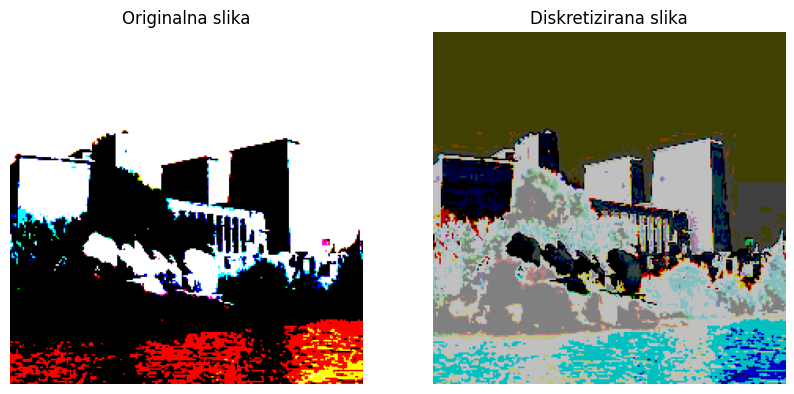

In [12]:
# prikaz originalne i diskretizirane slike
plt.subplots(1, 2, figsize=(10, 10))

plt.subplot(1,2,1)
plt.imshow(data[500])
plt.axis('off')  # Isključivanje oznaka osi ako ih ne želite
plt.title('Originalna slika')

plt.subplot(1,2,2)
plt.imshow(diskretizirane_slike[500])
plt.axis('off')  # Isključivanje oznaka osi ako ih ne želite
plt.title('Diskretizirana slika')
plt.show()

## Podjela skupa podataka

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Kreiranje modela

In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(200, activation='softmax')(x)

94765736/94765736 [==============================] - 0s 0us/step


In [15]:
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

## Treniranje modela

In [17]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
89/89 [==============================] - 25s 182ms/step - loss: 3.5044 - accuracy: 0.3121 - val_loss: 2.5925 - val_accuracy: 0.4449
Epoch 2/20
89/89 [==============================] - 11s 125ms/step - loss: 1.5538 - accuracy: 0.6229 - val_loss: 2.2896 - val_accuracy: 0.4788
Epoch 3/20
89/89 [==============================] - 11s 124ms/step - loss: 0.6788 - accuracy: 0.8302 - val_loss: 2.1926 - val_accuracy: 0.5523
Epoch 4/20
89/89 [==============================] - 11s 124ms/step - loss: 0.2826 - accuracy: 0.9347 - val_loss: 2.2667 - val_accuracy: 0.5438
Epoch 5/20
89/89 [==============================] - 11s 119ms/step - loss: 0.1148 - accuracy: 0.9806 - val_loss: 2.1025 - val_accuracy: 0.5734
Epoch 6/20
89/89 [==============================] - 11s 124ms/step - loss: 0.0389 - accuracy: 0.9979 - val_loss: 2.2981 - val_accuracy: 0.5537
Epoch 7/20
89/89 [==============================] - 11s 125ms/step - loss: 0.0222 - accuracy: 0.9986 - val_loss: 2.1805 - val_accuracy: 0.5777

## Evaluacija modela

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')

13/13 [==============================] - 2s 175ms/step - loss: 2.3386 - accuracy: 0.6244
Validation Loss: 2.3386, Validation Accuracy: 0.6244


### Grafik gubitka

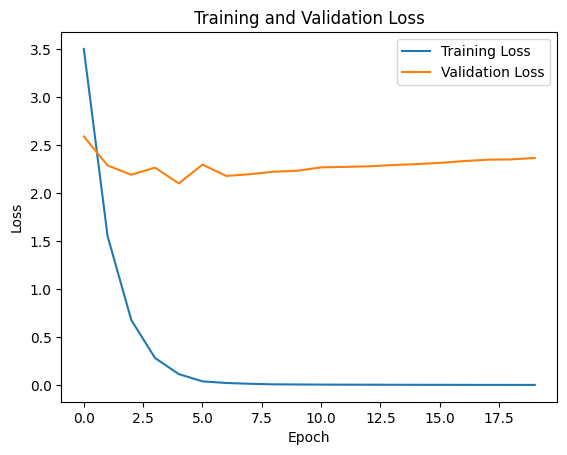

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Grafik tačnosti

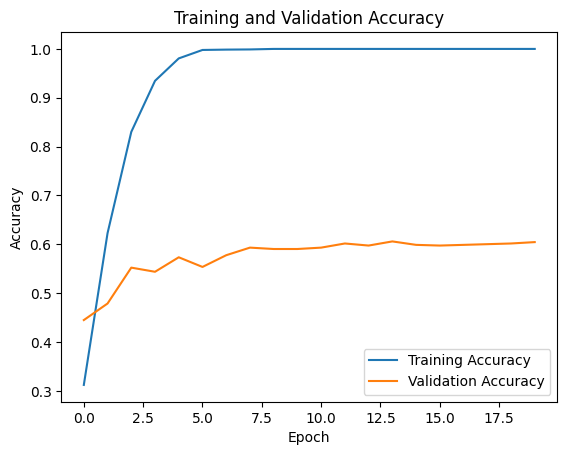

In [21]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Predikcija modela

In [22]:
predictions_probab = model.predict(X_test)
predictions = np.argmax(predictions_probab, axis=1)

predicted_labels = label_encoder.inverse_transform(predictions)

test_accuracy = np.sum(predictions == y_test) / len(y_test)
print(f'Calculated Test Accuracy: {test_accuracy:.4f}')

for i in range(10):
    if label_encoder.inverse_transform([y_test[i]])[0] == predicted_labels[i]:
      print(f"True Label: {label_encoder.inverse_transform([y_test[i]])[0]}, Predicted Label: {predicted_labels[i]}, SUCCESSFUL")
    else:
      print(f"True Label: {label_encoder.inverse_transform([y_test[i]])[0]}, Predicted Label: {predicted_labels[i]}, NOT SUCCESSFUL")

13/13 [==============================] - 2s 95ms/step
Calculated Test Accuracy: 0.6244
True Label: Pyramid_of_Khafra, Predicted Label: Pyramid_of_Khafra, SUCCESSFUL
True Label: Temple_of_Kom_Ombo, Predicted Label: Temple_of_Kom_Ombo, SUCCESSFUL
True Label: Pyramid_of_Djedkare_Isesi, Predicted Label: Pyramid_of_Djedkare_Isesi, SUCCESSFUL
True Label: Temple_of_Kom_Ombo, Predicted Label: Temple_of_Kom_Ombo, SUCCESSFUL
True Label: Na'ama_Bay, Predicted Label: Na'ama_Bay, SUCCESSFUL
True Label: Temple_of_Khonsu_in_Karnak, Predicted Label: Temple_of_Khonsu_in_Karnak, SUCCESSFUL
True Label: Sakakini_Palace, Predicted Label: Muizz_Street, NOT SUCCESSFUL
True Label: Fatimid_Cemetery_in_Aswan, Predicted Label: Na'ama_Bay, NOT SUCCESSFUL
True Label: Muizz_Street, Predicted Label: Muizz_Street, SUCCESSFUL
True Label: Ras_Muhammad, Predicted Label: Ras_Muhammad, SUCCESSFUL


## Korisnički interfejs

In [23]:
!pip install tensorflow
!pip install Pillow

import io
import ipywidgets as widgets
from IPython.display import display
from PIL import Image


def process_image(image):
    processed_img = cv2.resize(image, (224, 224))
    processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
    processed_img = np.array(processed_img)
    processed_img = np.expand_dims(processed_img, axis=0)
    processed_img = preprocess_input(processed_img)

    return processed_img

def process_and_display(change):
    with output_image:
        output_image.clear_output()

        if not uploaded_file.value:
            print("No file uploaded. Please upload an image.")
            return

        image_path = list(uploaded_file.value.keys())[0]

        print("Image path:", image_path)

        try:
            uploaded_image = Image.open(io.BytesIO(uploaded_file.value[image_path]["content"]))
            uploaded_image = np.array(uploaded_image)
            if uploaded_image is None:
                raise Exception("Error loading the image.")
        except Exception as e:
            print(f"Error: {e}")
            return

        processed_image = process_image(uploaded_image)
        prediction = model.predict(processed_image)
        predicted_class = labels[np.argmax(prediction)]

        plt.imshow(uploaded_image)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis("off")
        plt.show()

In [24]:
uploaded_file = widgets.FileUpload(accept='image/*', multiple=True)
button_process = widgets.Button(description="Process Image")
output_image = widgets.Output()

button_process.on_click(process_and_display)

display(widgets.VBox([uploaded_file, button_process, output_image]))

# Unos: Al-Fath Mosque
# Rezultat: Wadi Degla